# Analyzing Spectral Reflectance within Intertidal Zones

**Summary**
This tutorial demonstrates how to use Earth observation data from NASA's ECOSTRESS and EMIT missions alongside in situ spectral reflectance measurements to investigate environmental conditions and biodiversity in the intertidal zones of Southern California. Specifically, this notebook focuses on analyzing taxonomic diversity—such as algae types by comparing satellite data with groundtruthing reflectance spectra collected from tidepools. 

We aim to better understand how spectral signatures correspond to observable biological patterns by integrating:

- ECOSTRESS LST and emissivity layers (including LST, cloud mask, and quality control flags)

- EMIT full-band Level 2A reflectance data, and

- Normalized field-collected spectral data

Ultimately, the goal is to support coastal monitoring and climate adaptation efforts by incorporating various NASA missions

**Learning Objectives**

- What is spectral diversity and how does it relate to biodiversity?
- How to prepare and analyze reflectance data sets from on-ground and satellite observations. 
- Compare spectral diversity across sites and sensor types using summary statistics and visual plots.

**This Code Assumes You Have:** 
- A folder of ECOSTRESS .tif files (already downloaded) - https://ecostress.jpl.nasa.gov/downloads/tutorials/06-Downloading_from_AppEEARS.pdf
- One EMIT .nc NetCDF file with reflectance and wavelength bands - https://ecostress.jpl.nasa.gov/downloads/tutorials/06-Downloading_from_AppEEARS.pdf
- One normalized CSV for field reflectance (ground_truth_csv) - In situ data
- One .geojson polygon file for ROI - Created through coordinates or a polygon mapped in QGIS/ArcGIS
______________________________________________________________________________________________________________________________________________________

### Part 1: Data Setup and Dependencies

Create a working environment with required packages. Be sure to active your environment and choose the right kernel each time you work on your project.

In [1]:
# Setup & Imports
import warnings
warnings.filterwarnings("ignore")

# Import required libraries
import os
import json
import folium
import earthaccess
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import rioxarray as rxr
import earthaccess
import requests

from branca.element import Figure
from shapely.geometry import MultiPolygon, Polygon, box
from shapely.geometry.polygon import orient
from datetime import timedelta
from earthaccess import DataGranules
from pathlib import Path
from tqdm.notebook import tqdm

### Part 2: NASA Earthdata Authentication

To access data from NASA Earthdata, you must first authenticate using the earthaccess library. Follow the interactive login prompt that appears to sign in with your NASA Earthdata credentials (email and password associated with your Earthdata account). This step ensures you have authorized access to download and search Earth observation datasets.

If you haven’t registered yet, create a free account here: https://urs.earthdata.nasa.gov/users/new

In [2]:
# Authenticate with NASA Earthdata
auth = earthaccess.Auth()
auth.login(strategy="interactive", persist=True)
print('Authenticated:', auth.authenticated)

Authenticated: True


### Part 3: Define Paths

In order to put all the data together (ECOSTRESS, EMIT, In Situ), it is helpful to know where they are all located and assigning them to variables will help especially with longer file names. To download data for concurrent ECOSTRESS and EMIT data, refer to Intertidal.ipynb jupyter notebook.

In [13]:
# Define Paths
base_dir = Path("/Users/kylamonique/Desktop/JPLFiles/PythonCode") # Common folder for all inputs and outputs. 
ground_truth_csv = Path("/Users/kylamonique/Desktop/JPLFiles/NormalizedOutputs/LCDMNormalized.csv") #Normalized In situ csv for analysis.
roi_path = Path("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/LCDMPolygon.geojson") #Region of Interest
roi_point=Path("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/LCDMQuadrat.geojson")
ecostress_tif_path = Path("/Users/kylamonique/Desktop/JPLFiles/PythonCode/ECOSTRESS_Data/LCDM") #ECOSTRESS .tif folder (optional if not using earthdata)
emit_nc_path = Path("/Users/kylamonique/Desktop/JPLFiles/PythonCode/ECOSTRESS_Data/LCDM/PythonCode/ECOSTRESS_Data/LCDM/LCDM_ECO_L2T_LSTE.002_70m_aid0001_11N.nc")  # <-- Update this if your filename is different

ecostress_tif_path.mkdir(exist_ok=True) #make directory if it does not exist. 


### Part 4: Region of Interest

Have a polygon or coordinates to locate your region of interest as well as the CRS, so that your code knows which granules to collect from earthdata. 

In [4]:
# Load ROI for Clipping
roi_gdf = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/LCDMPolygon.geojson")
roi_proj = roi_gdf.to_crs("EPSG:4326")

#### Visualize the Sampling Locations 
Convert the dataset into a geodataframe and plot them on the map. This overall project focuses on three sites, but we are focusing on one at a time. The plotted map below visualizes where the sites are in proximity to one another, but only plots one area of interest at a time. 

       filename   latitude   longitude  Dist_Coast  Transect#  Quadrat#  \
0  IMG_2404.JPG  33.589467 -117.868247           0          1         1   
1  IMG_2405.JPG  33.589403 -117.868331          10          1         2   
2  IMG_2406.JPG  33.589353 -117.868414          20          1         3   
3  IMG_2407.JPG  33.589294 -117.868492          30          1         4   
4  IMG_2408.JPG  33.589247 -117.868592          40          1         5   

                      geometry  
0  POINT (-117.86825 33.58947)  
1   POINT (-117.86833 33.5894)  
2  POINT (-117.86841 33.58935)  
3  POINT (-117.86849 33.58929)  
4  POINT (-117.86859 33.58925)  
       filename   latitude   longitude  Dist_coast  Transect#  Quadrat#  \
0  IMG_8100.JPG  32.725650 -117.257706           0          1         1   
1  IMG_8101.JPG  32.725681 -117.257814          10          1         2   
2  IMG_8102.JPG  32.725758 -117.257897          20          1         3   
3  IMG_8104.JPG  32.725711 -117.257606           0 

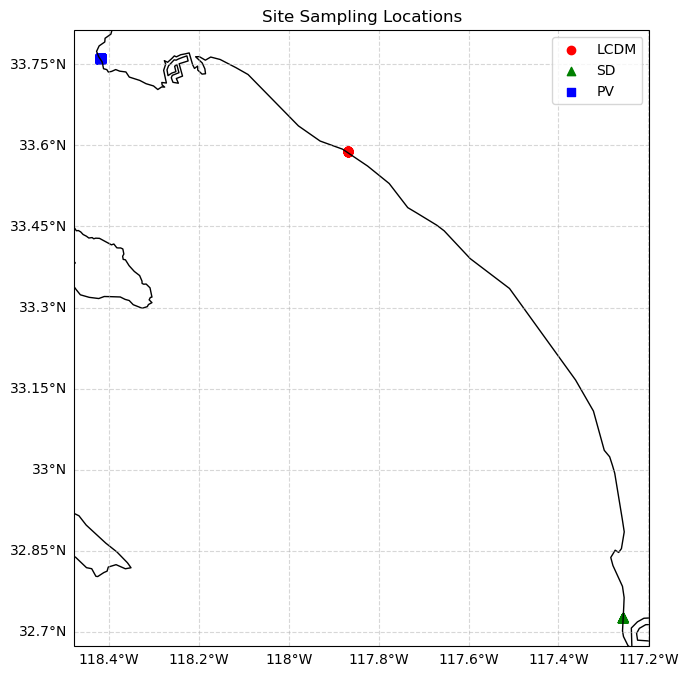

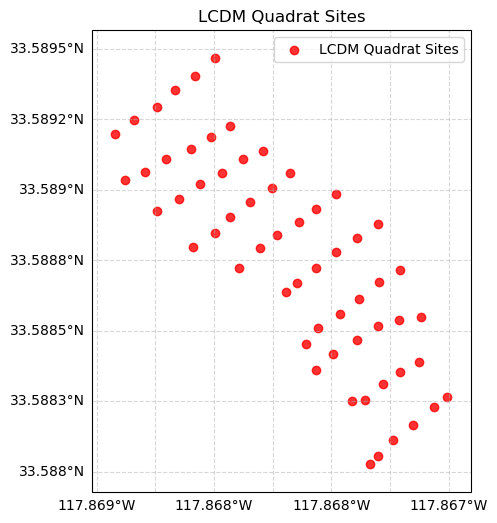

In [8]:
#Visualize Sample Locations on a Plot.
# Load GeoJSON files
LCDMQuadrat = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/LCDMQuadrat.geojson") #Change with correct filepath
SDQuadrat = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/SDQuadrat.geojson")
PVQuadrat = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/PVQuadrat.geojson")

print(LCDMQuadrat.head())
print(SDQuadrat.head())
print(PVQuadrat.head())

# Set up the plot with Cartopy for mapping
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add high-resolution coastlines and gridlines
ax.coastlines(resolution='10m')
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = gl.right_labels = False

# Plot the GeoDataFrames
LCDMQuadrat.plot(ax=ax, marker='o', color='red', label='LCDM', transform=ccrs.PlateCarree())
SDQuadrat.plot(ax=ax, marker='^', color='green', label='SD', transform=ccrs.PlateCarree())
PVQuadrat.plot(ax=ax, marker='s', color='blue', label='PV', transform=ccrs.PlateCarree())

plt.legend()
plt.title("Site Sampling Locations")
plt.show()


# Visualize all locations within one grid.
def plot_quadrats(gdf, title, color, marker):
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    
    ax.coastlines(resolution='10m')    # Plot coastlines
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)     # Gridlines
    gl.top_labels = gl.right_labels = False
    gdf.plot(ax=ax, color=color, marker=marker, alpha=0.8, transform=ccrs.PlateCarree(), label=title)     # Plot quadrats

    # Auto-zoom to the bounds of the GeoDataFrame (pad for clarity)
    minx, miny, maxx, maxy = gdf.total_bounds
    padding = 0.0001 # degree buffer
    ax.set_extent([minx - padding, maxx + padding, miny - padding, maxy + padding], crs=ccrs.PlateCarree())

    # Title and legend
    plt.title(title)
    plt.legend()
    plt.show()


# Visualize each location separately
#Coasts will not be visible due to space constraints.
plot_quadrats(LCDMQuadrat, "LCDM Quadrat Sites", "red", "o") 


#### Visualize Sample Locations on an Interactive Map. 

Map 1: Map 1 focuses only on one site.

Map 2: Map 2 shows all the sites in the study. 

In [17]:
# MAP 1 

# Load ROI polygon GeoJSON
LCDMpolygon = gpd.read_file(roi_path) 

#Load points within location
LCDM_points = gpd.read_file(roi_point)

# Combine to get a universal bounding box
combined = gpd.GeoDataFrame(pd.concat([LCDMpolygon], ignore_index=True), crs=LCDMpolygon.crs)
bbox = combined.total_bounds  # [minx, miny, maxx, maxy]
agu_bbox = gpd.GeoDataFrame(geometry=[combined.unary_union.envelope], crs=combined.crs)

# Create interactive map using folium and Google Satellite basemap
fig_roi = Figure(width="750px", height="375px")
map_roi = folium.Map(
    tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', 
    attr='Google Satellite', 
    name='Google Satellite'
)
fig_roi.add_child(map_roi)

# Add bounding box layer
folium.GeoJson(
    agu_bbox,
    name='Bounding Box'
).add_to(map_roi)

# Add all 3 polygons to the map with different colors
LCDMpolygon.explore(
    m=map_roi,
    name="LCDM",
    column=None,
    style_kwds=dict(color="red", fillOpacity=0.1, weight=10),
    popup=True
)


# Add LCDM points
for _, row in LCDM_points.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color="red",
        fill=True,
        fill_color="red",
        popup=row.get("name", "LCDM Point")
    ).add_to(map_roi)

# Add layer control toggle
map_roi.add_child(folium.LayerControl())

# Fit map bounds to the union of all 3 polygons
minx, miny, maxx, maxy = combined.total_bounds
map_roi.fit_bounds(bounds=((miny, minx), (maxy, maxx)))

# Show map
fig_roi


In [ ]:
#MAP 2: Untoggle to load all sites. 

# Load all 3 ROI polygon GeoJSONs
LCDMpolygon = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/LCDMPolygon.geojson")
SDpolygon   = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/SDPolygon.geojson")
PVpolygon   = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/PVPolygon.geojson")

#Load points within locations
LCDM_points = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/LCDMQuadrat.geojson")
SD_points   = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/SDQuadrat.geojson")
PV_points   = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/PVQuadrat.geojson")


# Combine to get a universal bounding box
combined = gpd.GeoDataFrame(pd.concat([LCDMpolygon, SDpolygon, PVpolygon], ignore_index=True), crs=LCDMpolygon.crs)
bbox = combined.total_bounds  # [minx, miny, maxx, maxy]
agu_bbox = gpd.GeoDataFrame(geometry=[combined.unary_union.envelope], crs=combined.crs)

# Create interactive map using folium and Google Satellite basemap
fig_roi = Figure(width="750px", height="375px")
map_roi = folium.Map(
    tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', 
    attr='Google Satellite', 
    name='Google Satellite'
)
fig_roi.add_child(map_roi)

# Add bounding box layer
folium.GeoJson(
    agu_bbox,
    name='Bounding Box'
).add_to(map_roi)

# Add all 3 polygons to the map with different colors
LCDMpolygon.explore(
    m=map_roi,
    name="LCDM",
    column=None,
    style_kwds=dict(color="red", fillOpacity=0.1, weight=10),
    popup=True
)

SDpolygon.explore(
    m=map_roi,
    name="SD",
    column=None,
    style_kwds=dict(color="green", fillOpacity=0.1, weight=10),
    popup=True
)

PVpolygon.explore(
    m=map_roi,
    name="PV",
    column=None,
    style_kwds=dict(color="blue", fillOpacity=0.1, weight=10),
    popup=True
)

# Add LCDM points
for _, row in LCDM_points.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color="red",
        fill=True,
        fill_color="red",
        popup=row.get("name", "LCDM Point")
    ).add_to(map_roi)

# Add SD points
for _, row in SD_points.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color="green",
        fill=True,
        fill_color="green",
        popup=row.get("name", "SD Point")
    ).add_to(map_roi)

# Add PV points
for _, row in PV_points.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color="blue",
        fill=True,
        fill_color="blue",
        popup=row.get("name", "PV Point")
    ).add_to(map_roi)



# Add layer control toggle
map_roi.add_child(folium.LayerControl())

# Fit map bounds to the union of all 3 polygons
minx, miny, maxx, maxy = combined.total_bounds
map_roi.fit_bounds(bounds=((miny, minx), (maxy, maxx)))

# Show map
fig_roi


### Part 5: Load In Situ Data

Load in and preview the in situ dataset.

In [5]:
if ground_truth_csv.exists():
    ground_df = pd.read_csv(ground_truth_csv)
    print("Ground truth data sample:")
    display(ground_df.head())
else:
    print("❌ No ground truth CSV found.")
    ground_df = None

Ground truth data sample:


,wavelength,1594452_00092,1594452_00093,1594452_00094,1594452_00095,1594452_00096,1594452_00097,1594452_00098,1594452_00099,1594452_00100,...,1594452_00264,1594452_00265,1594452_00266,1594452_00267,1594452_00268,1594452_00269,1594452_00270,1594452_00271,1594452_00272,1594452_00273
0,400,0.018298,0.017745,0.017955,0.015651,0.015837,0.065530,0.068105,0.062954,0.115893,...,0.127053,0.136496,0.127053,0.091570,0.082413,0.086133,0.089281,0.021462,0.024896,0.026040
1,401,0.019064,0.018499,0.018668,0.016294,0.016459,0.064161,0.067242,0.060935,0.116348,...,0.126078,0.137052,0.127786,0.091195,0.081049,0.084990,0.089758,0.021664,0.025739,0.026394
2,402,0.019367,0.018807,0.018969,0.016571,0.016708,0.063914,0.067121,0.061549,0.117084,...,0.125759,0.137644,0.128149,0.090486,0.081416,0.085159,0.089506,0.021034,0.025592,0.026390
3,403,0.019353,0.018805,0.018998,0.016600,0.016714,0.064941,0.067849,0.064457,0.118009,...,0.126248,0.137879,0.127944,0.089658,0.083115,0.086265,0.088446,0.019870,0.024474,0.025928
4,404,0.019085,0.018540,0.018722,0.016359,0.016470,0.064831,0.069500,0.064265,0.118548,...,0.127177,0.137782,0.127307,0.090151,0.082523,0.084499,0.088514,0.020519,0.024880,0.025324


#### Visualize the Spectral Reflectance

Visualize the different transects of your site to analyze the spectra. 

In [9]:
"""
    Plots the average of each quadrat's columns. Each quadrat was taken three times. 
    Creates one plot per average of quadrat field takes. 

    Parameters:
    df (pd.DataFrame): DataFrame with 'wavelength' in first column and reflectance data from start_col_index onward
    start_col_index (int): Index to start processing reflectance columns
    group_size (int): How many columns to average together
    sets_per_plot (int): How many averaged groups per plot
"""
def plot_avg_groups(df, start_col_index=6, group_size=3, sets_per_plot=6):
    cols = df.columns[start_col_index:]
    num_groups = len(cols) // group_size
    group_labels = []

    for i in range(0, num_groups * group_size, group_size):
        group_cols = cols[i:i+group_size]
        avg_label = f"Avg_{group_cols[0]}_to_{group_cols[-1]}"
        group_labels.append(avg_label)
        df[avg_label] = df[group_cols].mean(axis=1)

    # Plot in sets
    for plot_start in range(0, num_groups, sets_per_plot):
        plt.figure(figsize=(10, 6))
        for label in group_labels[plot_start:plot_start + sets_per_plot]:
            plt.plot(df["wavelength"], df[label], label=label)
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Average Normalized Reflectance")
        plt.title(f"LCDM Transect {plot_start // sets_per_plot + 1}")
        plt.legend()
        plt.grid(True)
        plt.show()


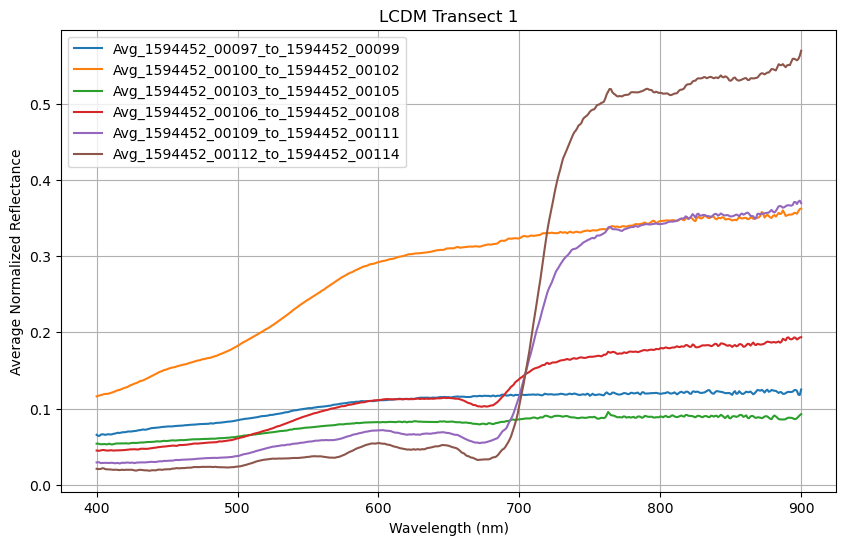

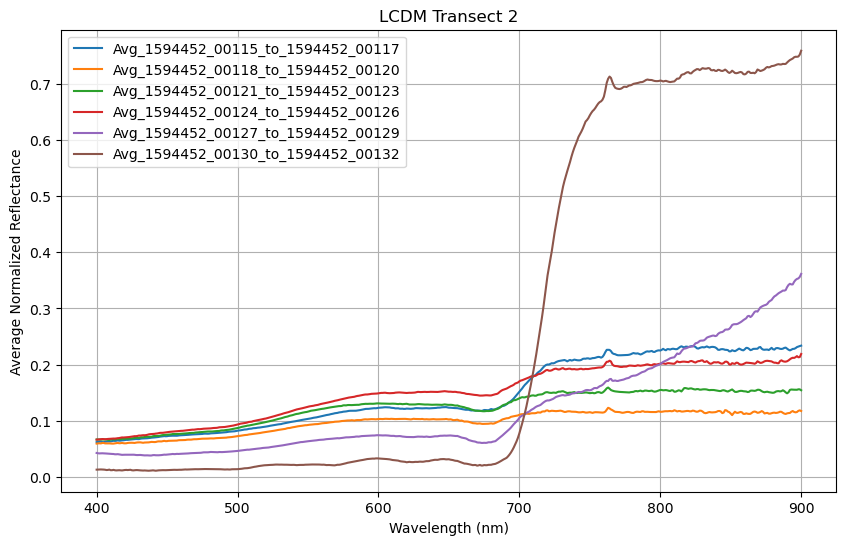

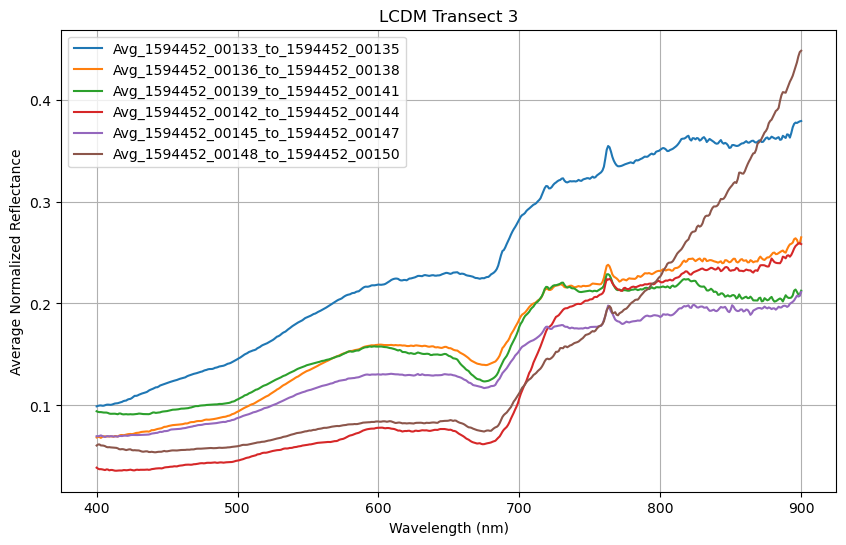

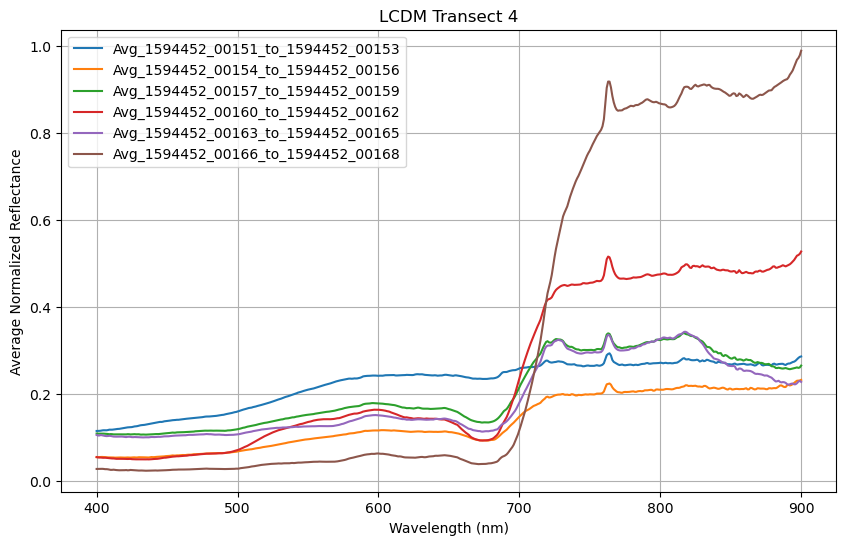

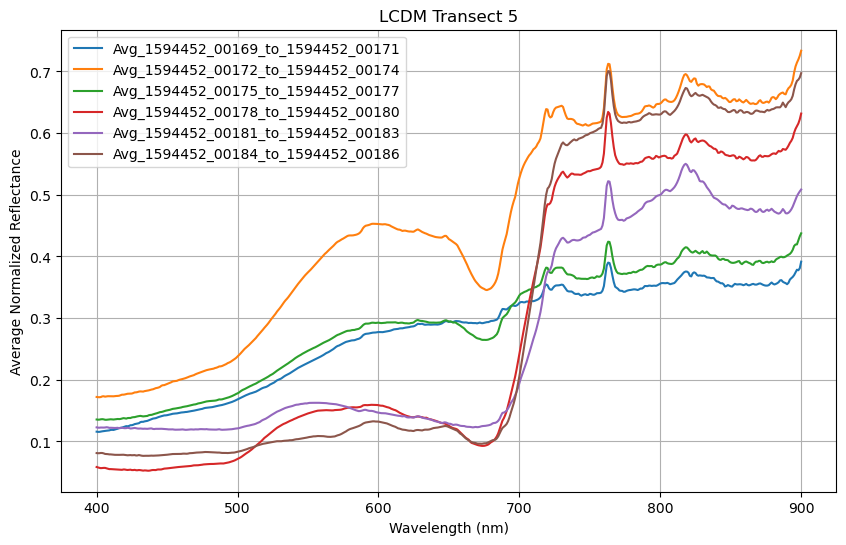

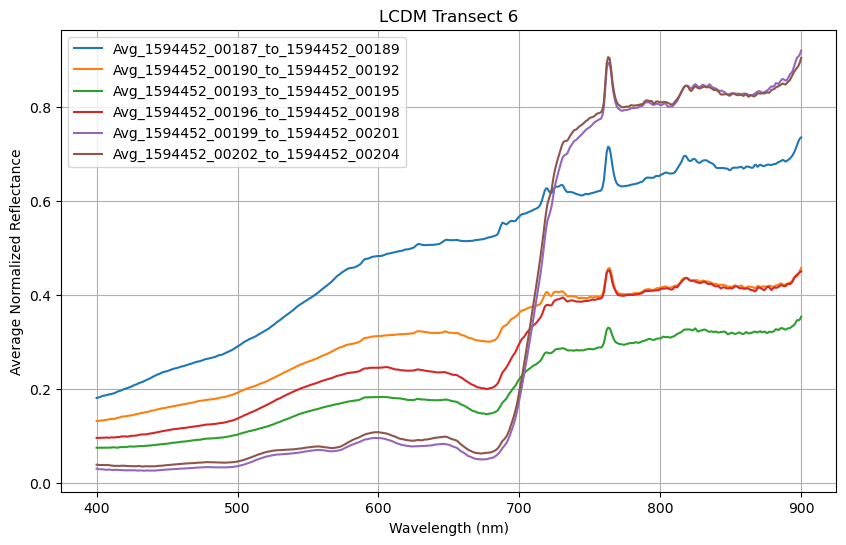

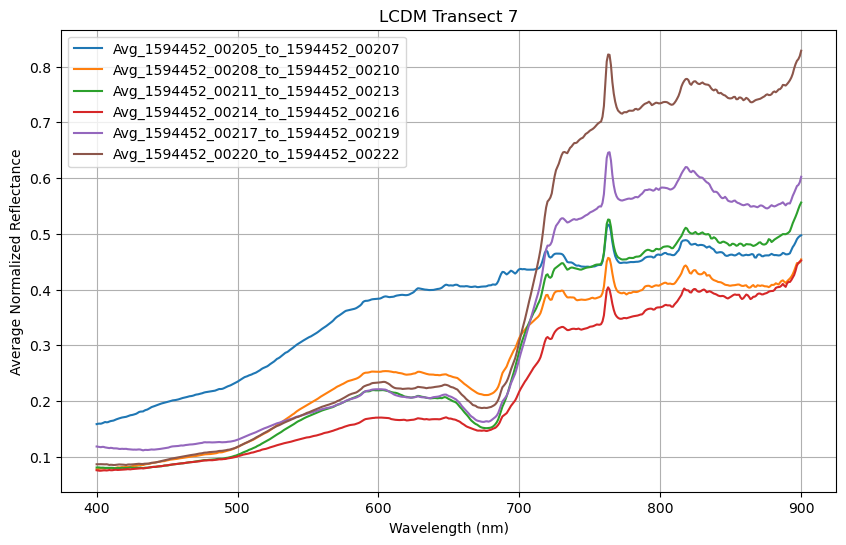

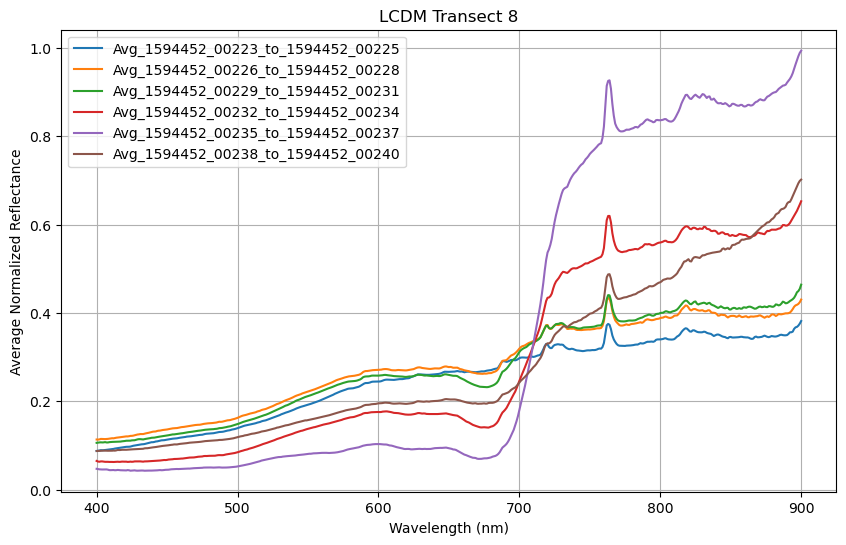

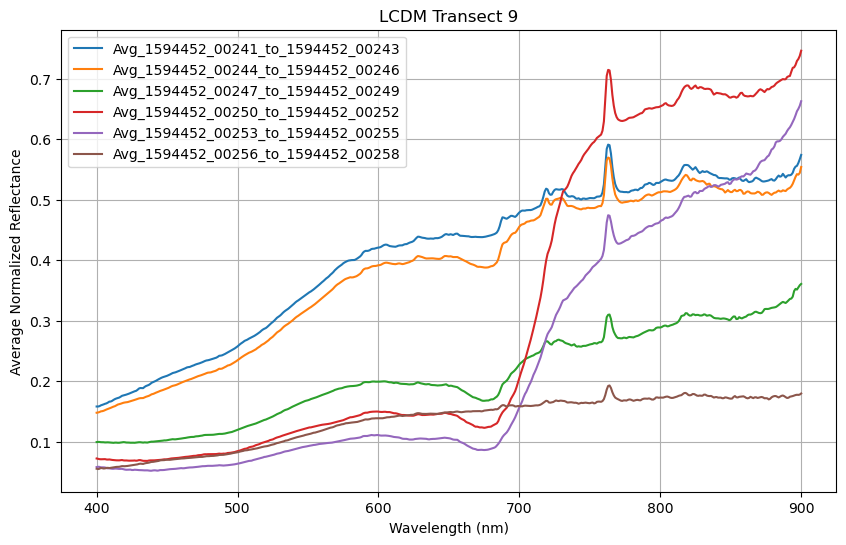

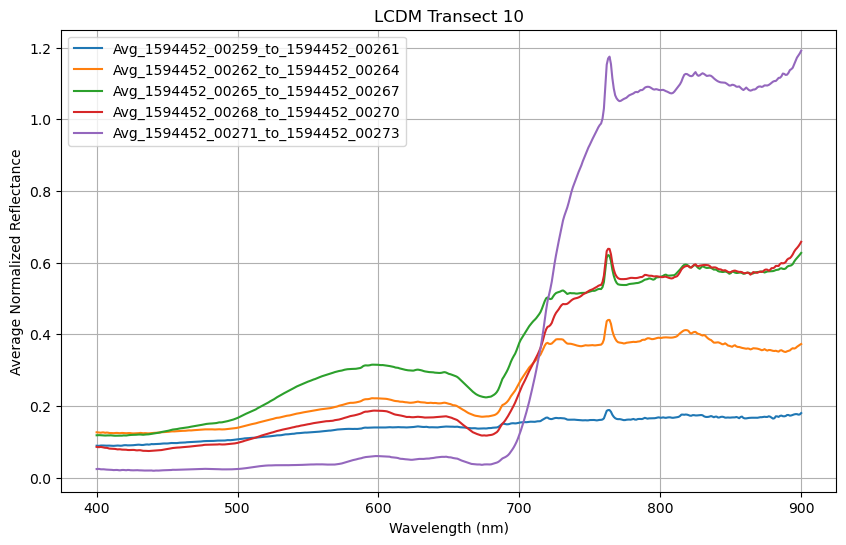

In [10]:
# Load your data
ground_df = pd.read_csv(ground_truth_csv)

# Run the function
plot_avg_groups(ground_df)

Plot out all the coefficients of variations. 

### Part 6: Set Search Parameters and Query ECOSTRESS + EMIT

### Part 6: Process ECOSTRESS

Proces ECOSTRESS Data first. 

In [ ]:
all_files = os.listdir(ecostress_tif_path)
lst_files = sorted([f for f in all_files if "_LST" in f and f.endswith(".tif")])
qc_files = sorted([f for f in all_files if "_QC" in f and f.endswith(".tif")])
cloud_files = sorted([f for f in all_files if "_cloud" in f and f.endswith(".tif")])


def subset_and_plot(file_name, title):
    fpath = ecostress_tif_path / file_name
    if not fpath.exists():
        print(f"File not found: {file_name}")
        return
    da = rxr.open_rasterio(fpath, masked=True).squeeze()
    da = da.rio.write_crs("EPSG:4326")
    clipped = da.rio.clip(roi_proj.geometry, roi_proj.crs, drop=True)

    plt.figure(figsize=(8, 5))
    clipped.plot(cmap="viridis")
    plt.title(title)
    plt.show()

if lst_files:
    subset_and_plot(lst_files[0], "ECOSTRESS LST")
if cloud_files:
    subset_and_plot(cloud_files[0], "ECOSTRESS Cloud Mask")
if qc_files:
    subset_and_plot(qc_files[0], "ECOSTRESS QC")

### Part 7: Load and Process EMIT Data

In [ ]:
if emit_nc_path.exists():
    ds_emit = xr.open_dataset(emit_nc_path, engine="netcdf4")

    # Extract reflectance and wavelength
    reflectance = ds_emit["Reflectance"]
    wavelengths = ds_emit["wavelength"]

    # Clip to ROI
    clipped_reflectance = reflectance.rio.write_crs("EPSG:4326").rio.clip(roi_proj.geometry, roi_proj.crs, drop=True)

    # Average across all pixels in ROI
    mean_emit_spectrum = clipped_reflectance.mean(dim=["x", "y"]).values
    wavelength_vals = wavelengths.values

    emit_loaded = True
    print("✅ EMIT reflectance loaded and clipped.")
else:
    print("❌ EMIT NetCDF not found.")
    emit_loaded = False
